In [2]:
import datetime as dt
import numpy as np
import os
import xarray as xr
import utils
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 12,5
import matplotlib.pyplot as plt
import glob
import pandas as pd
from utils import read_tdump
from itertools import cycle
from geographiclib.geodesic import Geodesic
import time
import met_utils as mu

%load_ext autoreload
%autoreload 2

In [2]:
data_RF06 = xr.open_dataset('/home/disk/eos4/jkcm/Data/CSET/Lagrangian_project/trajectory_files/rf06_all_traj_2.3.nc')
data_RF10 = xr.open_dataset('/home/disk/eos4/jkcm/Data/CSET/Lagrangian_project/trajectory_files/rf10_all_traj_6.0.nc')

In [103]:
def get_from_inv(ERA_data, varname):
    z = ERA_data.ERA_z.values/9.81
    theta = mu.theta_from_p_T(p=np.broadcast_to(ERA_data.level.values, z.shape), T=ERA_data.ERA_t.values)
    heff = mu.heffter_pblht_2d(z, theta)
    ret = np.empty_like(ERA_data.time.values).astype(float)
    for i, (b, t) in enumerate(zip(heff['i_bot'].astype(int), heff['i_top'].astype(int))):
        ret[i] = np.nanmean(ERA_data[varname][i,slice(min(b,t), max(b,t))])
    return ret
w_06 = get_from_inv(data_RF06, 'ERA_w')
w_10 = get_from_inv(data_RF10, 'ERA_w')

    
# mask = np.zeros_like(z).astype(bool)
# print(mask.shape)
# for i, (b, t) in enumerate(zip(heff['i_bot'].astype(int), heff['i_top'].astype(int))):
#     mask[i,slice(min(b,t), max(b,t))] = True
    
# data.ERA_z.values[mask]

In [1]:
fig, [ax1, ax2] = plt.subplots(nrows=2, figsize=(20,20))
for plevel in [1000, 900, 800, 700]:

    p1 = ax1.plot(data_RF06.ERA_w.sel(level=plevel), label=str(plevel))
    ax1.axhline(np.nanmean(data_RF06.ERA_w.sel(level=plevel)), ls='--', c=p1[0].get_color())
    p2 = ax2.plot(data_RF10.ERA_w.sel(level=plevel), label=str(plevel))
    ax2.axhline(np.nanmean(data_RF10.ERA_w.sel(level=plevel)), ls='--', c=p2[0].get_color())

p1 = ax1.plot(w_06, label='inv', c='k')
ax1.axhline(np.nanmean(w_06), ls='--', c='k')
ax1.title('RF06, traj 2.3')
ax2.plot(w_10, label='inv', c='k')    
ax2.axhline(np.nanmean(w_10), ls='--', c='k')
ax1.title('RF10, traj 6.0')
ax1.legend()
ax2.legend()

NameError: name 'plt' is not defined

In [79]:
plevel=800

def DEC_get_traj_massbudget(data, plevel, d_inv_dt):
    rho = mu.density_from_p_Tv(plevel*100, Tv=data.ERA_t.sel(level=plevel))  # TODO get virtual temp right
    hgts = data.ERA_z.sel(level=plevel)/9.81
    dzdt = np.gradient(hgts)/np.full_like(hgts, 3600)
    dsbpdt = np.gradient(data.ERA_sp)/np.full_like(hgts, 3600)
    x_div = data.ERA_dudx.sel(level=slice(plevel, 1000)).mean(axis=1)*hgts
    y_div = data.ERA_dvdy.sel(level=slice(plevel, 1000)).mean(axis=1)*hgts
    w = data.ERA_w.sel(level=plevel)/(rho*9.81)
    div = (x_div + y_div)
    mean_div = np.mean(div)
    mean_sub = np.mean(w)
#     dinvdt = d_inv/(72*60*60)
    dinvdt = d_inv_dt
    we = dinvdt + mean_sub
    
    ret_dict = dict(rho=rho, hgts=hgts, dzdt=dzdt, dspdt=dspdt, x_div=x_div, y_div=y_div,
                   w=w, div=div, mean_div=mean_div, mean_sub=mean_sub, we=we, d_inv_dt=d_inv_dt, dinvdt=dinvdt)
    return(ret_dict)

def get_traj_massbudget(data, plevel, d_inv_dt):

#     if plevel=='Heff':
    if True:
        theta = mu.theta_from_p_T(data.level, data.ERA_t).values
        inv = np.zeros(theta.shape[0])
#         inv_i = np.zeros(theta.shape[0])
        plevel = np.zeros(theta.shape[0])
        hgts, x_div, y_div, w = [], [], [], []
        for i in range(theta.shape[0]):
            time = data.time[i]
            inv[i] = mu.heffter_pblht_1D(data.ERA_z.values[i]/9.81, theta[i])['z_top']
            idx = mu.heffter_pblht_1D(data.ERA_z.values[i]/9.81, theta[i])['i_top']
#             print(idx)
            pres = data.level[idx]
            plevel[i] = pres
            Tv=data.ERA_t.sel(level=pres, time=time).values.squeeze()
            rho = mu.density_from_p_Tv(pres*100, Tv=Tv)  # TODO get virtual temp right
            hgt = data.ERA_z.sel(level=pres, time=time)/9.81
            hgts.append(hgt)
            x_div.append(data.ERA_dudx.sel(level=slice(pres, 1000), time=time).mean()*hgt)
            y_div.append(data.ERA_dvdy.sel(level=slice(pres, 1000), time=time).mean()*hgt)
            w.append(data.ERA_w.sel(level=pres, time=time)/(rho*9.81))

#     f, [a1, a2] = plt.subplots(ncols=2)
#     pc = a1.pcolormesh(data.time, data.level, data.ERA_t.T, vmin=280, vmax=295)
#     plt.colorbar(pc)
#     a1.plot(data.time, data.pres)
#     a1.set_ylim(1000, 800)
#     a2.pcolormesh(data.time, data.time, Tv, vmin=280, vmax=295)

#     plevel = data.pres
#     Tv=data.ERA_t.interp(level=plevel).values.squeeze()    
#     rho = mu.density_from_p_Tv(plevel*100, Tv=data.ERA_t.interp(level=plevel))  # TODO get virtual temp right
    

#     hgts = data.ERA_z.sel(level=plevel, method='nearest')/9.81
    dzdt = np.gradient(hgts)/np.full_like(hgts, 3600)
    dspdt = np.gradient(data.ERA_sp)/np.full_like(hgts, 3600)
#     x_div = data.ERA_dudx.sel(level=slice(plevel, 1000)).mean(axis=1)*hgts
#     y_div = data.ERA_dvdy.sel(level=slice(plevel, 1000)).mean(axis=1)*hgts
#     w = data.ERA_w.sel(level=plevel, method='nearest')/(rho*9.81)
    div = (x_div + y_div)
    mean_div = np.mean(div)
    mean_sub = np.mean(w)
#     dinvdt = d_inv/(72*60*60)
    dinvdt = d_inv_dt
    we = dinvdt + mean_sub
    
    ret_dict = dict(rho=rho, hgts=hgts, dzdt=dzdt, dspdt=dspdt, x_div=x_div, y_div=y_div,
                   w=w, div=div, mean_div=mean_div, mean_sub=mean_sub, we=we, d_inv_dt=d_inv_dt, dinvdt=dinvdt)
    

    return(ret_dict)
        
# RF06_MB = get_traj_massbudget(data_RF06, plevel=plevel, d_inv=(2400-800))
# RF10_MB = get_traj_massbudget(data_RF10, plevel=plevel, d_inv=(1800-1200))
RF06_MB = get_traj_massbudget(data_RF06, plevel=plevel, d_inv_dt=4.17/1000)
RF10_MB = get_traj_massbudget(data_RF10, plevel=plevel, d_inv_dt=1.51/1000)

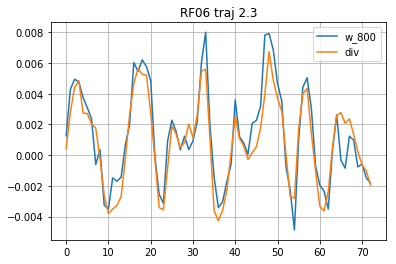

In [31]:
plt.plot(RF06_MB['w'], label='w_800')
plt.plot(RF06_MB['div'], label='div')
#plt.plot(RF06_MB['div'] + RF06_MB['dspdt']/(RF06_MB['rho']*9.81), label='div+dspdt')

# plt.plot(w_corr, label='w (corr)')

# plt.plot(x_div, label='x-div')
# plt.plot(y_div, label='y-div')
# plt.plot(RF06_MB['dzdt'], label='-dzdt')
plt.legend()
plt.title("RF06 traj 2.3")
plt.grid(True)

In [80]:

plt.plot(w_2, label='w_700')
plt.plot(div_2, label='div')
plt.plot(x_div_2, label='x-div')
plt.plot(y_div_2, label='y-div')
plt.title("RF10 traj 6.0")
plt.legend()
plt.grid(True)

NameError: name 'w_2' is not defined

In [81]:

print("rf06: sub({:0.2f}) + dinvdt({:0.2f}) = we({:0.2f})".format(
    RF06_MB['mean_sub'].values*1000, RF06_MB['dinvdt']*1000, RF06_MB['we'].values*1000))
print("rf06: div({:0.2f})".format(RF06_MB['mean_div'].values*1000))


print("rf10: sub({:0.2f}) + dinvdt({:0.2f}) = we({:0.2f})".format(
    RF10_MB['mean_sub'].values*1000, RF10_MB['dinvdt']*1000, RF10_MB['we'].values*1000))
print("rf10: div({:0.2f})".format(RF10_MB['mean_div'].values*1000))

AttributeError: 'numpy.float64' object has no attribute 'values'

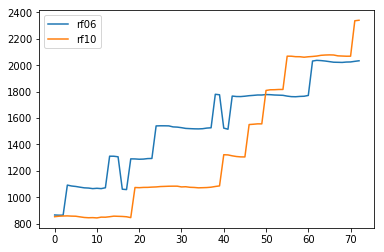

In [86]:
plt.plot(RF06_MB['hgts'],label='rf06')
plt.plot(RF10_MB['hgts'],label='rf10')
plt.legend()

In [ ]:

print("rf06: sub({:0.2f}) + dinvdt({:0.2f}) = we({:0.2f})".format(
    RF06_MB['mean_sub']*1000, RF06_MB['dinvdt']*1000, RF06_MB['we']*1000))
print("rf06: div({:0.2f})".format(RF06_MB['mean_div']*1000))


print("rf10: sub({:0.2f}) + dinvdt({:0.2f}) = we({:0.2f})".format(
    RF10_MB['mean_sub']*1000, RF10_MB['dinvdt']*1000, RF10_MB['we']*1000))
print("rf10: div({:0.2f})".format(RF10_MB['mean_div']*1000))

Text(0,0.5,'SST (K)')

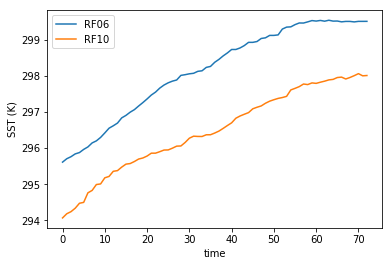

In [16]:
rf06_sst = data_RF06.ERA_sst
rf10_sst = data_RF10.ERA_sst
plt.plot(rf06_sst, label='RF06')
plt.plot(rf10_sst, label='RF10')
plt.legend()
plt.xlabel('time')
plt.ylabel('SST (K)')

In [17]:
# data_RF06.data_vars

rf06_shf = data_RF06.ERA_ishf  
rf06_lhf = data_RF06.ERA_ie*2264.705*1000  
rf10_shf = data_RF10.ERA_ishf  
rf10_lhf = data_RF10.ERA_ie*2264.705*1000  

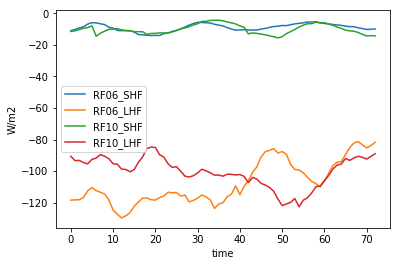

In [18]:
plt.plot(rf06_shf, label='RF06_SHF')
plt.plot(rf06_lhf, label='RF06_LHF')
plt.plot(rf10_shf, label='RF10_SHF')
plt.plot(rf10_lhf, label='RF10_LHF')
plt.ylabel("W/m2")
plt.xlabel('time')
plt.legend()

In [45]:
mu.heffter_pblht_1D(data.ERA_z.values[0]/9.81, theta[0])

{'i_bot': 36,
 'i_top': 33,
 'inversion': True,
 'theta_bot': 293.33816077568287,
 'theta_top': 295.4847699446006,
 'z_bot': 561.5733383967657,
 'z_top': 919.2303477926621}

(0, 5000)

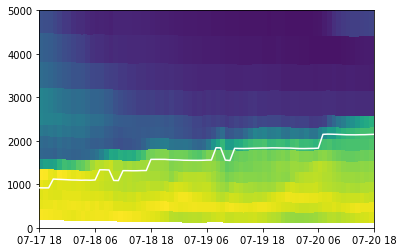

In [65]:
X = np.broadcast_to(data.time.values[:,None], data.ERA_r.values.shape)
plt.pcolor(X, data.ERA_z.values/9.81, data.ERA_r.values, zorder=2)
plt.plot(data.time, inv, zorder=10, c='w')
plt.ylim(0, 5000)

In [57]:
data.time

<xarray.DataArray 'time' (time: 73)>
array(['2015-07-17T18:00:00.000000000', '2015-07-17T19:00:00.000000000',
       '2015-07-17T20:00:00.000000000', '2015-07-17T21:00:00.000000000',
       '2015-07-17T22:00:00.000000000', '2015-07-17T23:00:00.000000000',
       '2015-07-18T00:00:00.000000000', '2015-07-18T01:00:00.000000000',
       '2015-07-18T02:00:00.000000000', '2015-07-18T03:00:00.000000000',
       '2015-07-18T04:00:00.000000000', '2015-07-18T05:00:00.000000000',
       '2015-07-18T06:00:00.000000000', '2015-07-18T07:00:00.000000000',
       '2015-07-18T08:00:00.000000000', '2015-07-18T09:00:00.000000000',
       '2015-07-18T10:00:00.000000000', '2015-07-18T11:00:00.000000000',
       '2015-07-18T12:00:00.000000000', '2015-07-18T13:00:00.000000000',
       '2015-07-18T14:00:00.000000000', '2015-07-18T15:00:00.000000000',
       '2015-07-18T16:00:00.000000000', '2015-07-18T17:00:00.000000000',
       '2015-07-18T18:00:00.000000000', '2015-07-18T19:00:00.000000000',
       '2015-0